<a href="https://colab.research.google.com/github/soichi-fujiwara/jupyter-notebook/blob/master/Web_scraping_Qiita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install beautifulsoup4
!pip install mecab-python3

     |████████████████████████████████| 15.9MB 2.8MB/s 


In [0]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
#import MeCab
from google.colab import files

# 親ページURL(検索ワード指定：python 実務 ソート:ストック順)
url_pr = 'https://qiita.com/search?page={0}&q=python+%E5%AE%9F%E5%8B%99&sort=stock'
# 子ページURL(ベース)
url_c_base = 'https://qiita.com/' 

# データフレームを定義
columns = ["タイトル名","URL","単語"]
df = pd.DataFrame(columns=columns)

#親ページ20ページ分
#※1からindex21まで
for i in range(1,21):

  html_doc = requests.get(url_pr.format(i)).text

  # BeautifulSoupでスクレイピング
  soup = BeautifulSoup(html_doc, 'html.parser')
  # ラッピング単位のクラスを取得
  contents  = soup.find_all("div", {"class": "searchResult_main"})

  for content in contents:
    content_data = content.find("h1", {"class": "searchResult_itemTitle"})

    #子ページタイトル
    content_name = content_data.text
    #子ページURL
    chilld_link = url_c_base + str(content_data.a.get("href")) 

    html_c_doc = requests.get(chilld_link).text
    soup_c = BeautifulSoup(html_c_doc, 'html.parser')

    # 子ページ内の単語を取得
    code_word = ''
    contents_c  = soup_c.find_all("div", {"class": "code-frame"})
    for code_word_list in contents_c:
      code_word = code_word + code_word_list.text

    # 各データをデータフレームに格納
    se = pd.Series([content_name, chilld_link,code_word], columns)
    df = df.append(se, columns)

# 収集したデータをCSV形式で保存
filename = "Qiita_python_list.csv"
df.to_csv(filename, encoding = 'utf-8')
files.download(filename)

In [0]:
import re

def serialize_q(words):
  
  #数値無効化
  words = re.sub(r'[0-9]', ' ', words)
  #全角記号無効化
  words = re.sub(r'[︰-＠]', ' ', words)
  #改行無効化
  words = re.sub('\n', ' ', words)
  #タグ無効化
  words = re.sub(r"<[^>]*?>", ' ', words)
  #漢字無効化
  words = re.sub('[一-鿐]', ' ', words)
  #ひらがな無効化
  words = re.sub('[ぁ-ゟ]', ' ', words)
  #カタカナ無効化
  words = re.sub('[\ァ-ヿ]', ' ', words)
  #1文字以上の空白文字無効化
  words = re.sub(r'[\s+]', ' ', words)
  

  #特定記号無効化
  del_word = [",",".","-","=","<",">","(",")","{","}","[","]","_","#",":","+","*","@",";","/"]
  for word in del_word:
    words = words.replace(word,' ')
  
  return words

In [5]:
import MeCab
import itertools
from collections import Counter

#コーパス作成
df2 = df[["単語"]]
str_wk = ''

#listを文字列に連結
for index,item in df2.iterrows():
    str_wk = str_wk + str(item['単語'])

#正規化
text = serialize_q(str_wk)

#分かち書き  
tagger = MeCab.Tagger("-Owakati")
word_list_wk = (tagger.parse(text)).split(' ') 

#文字列長がNByte以上の単語のみピックアップ
word_list = [e for e in word_list_wk if len(e) >= 3]
#word_list = word_list_wk

#単語カウント
mycounter = Counter(word_list)

#先頭N項目を確認
word_cnt_list = []
for word_rank in mycounter.most_common(40):
  word_cnt_list.append(word_rank)

word_cnt_list

[('import', 334),
 ('from', 145),
 ('print', 109),
 ('name', 106),
 ('git', 98),
 ('include', 91),
 ('list', 86),
 ('data', 81),
 ('python', 74),
 ('for', 72),
 ('index', 69),
 ('test', 63),
 ('plt', 61),
 ('hoge', 57),
 ('number', 54),
 ('def', 51),
 ('val', 51),
 ('install', 51),
 ('sample', 51),
 ('project', 51),
 ('String', 50),
 ('null', 50),
 ('feature', 50),
 ('sum', 49),
 ('type', 48),
 ('let', 47),
 ('Int', 47),
 ('version', 45),
 ('fib', 43),
 ('int', 42),
 ('using', 42),
 ('prefix', 42),
 ('std', 41),
 ('iris', 41),
 ('tmp', 41),
 ('train', 40),
 ('func', 39),
 ('namespace', 39),
 ('mnist', 39),
 ('value', 38)]

In [0]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([(tag, {"count":count}) for tag, count in word_cnt_list])

#word_list(生データ)
for tags in word_list:
    for tag0, tag1 in itertools.combinations(tags, 2):
        if not G.has_node(tag0) or not G.has_node(tag1):
            continue
        if G.has_edge(tag0, tag1):
            G[tag0][tag1]["weight"] += 1
        else:
            G.add_edge(tag0, tag1, weight=1)

(-1.0838288921298218,
 1.1525164153631797,
 -1.1018507054996216,
 1.1085417148468921)

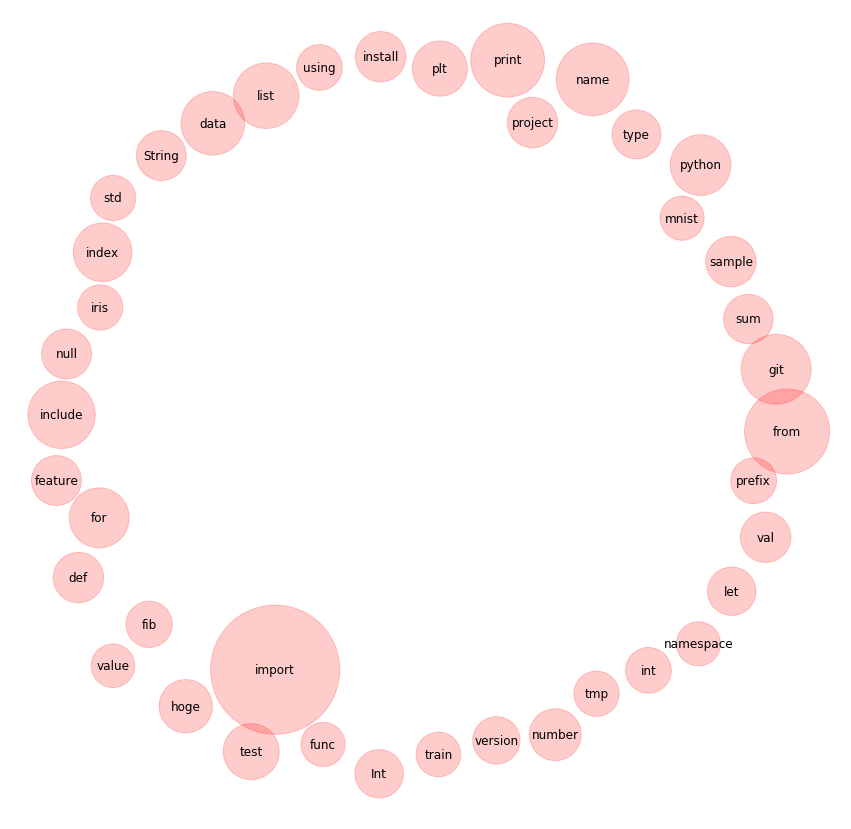

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# グラフのサイズを定義
plt.figure(figsize=(15,15))

# ノード間の反発力を定義。値が小さいほど密集する
pos = nx.spring_layout(G, k=1.0)

# ノードの大きさを調整
node_size = [ d['count']*50 for (n,d) in G.nodes(data=True)] 

# ノードのスタイルを定義
nx.draw_networkx_nodes(G, pos, node_color='r', alpha=0.2, node_size=node_size, font_weight="bold", font_family='VL Gothic')
nx.draw_networkx_labels(G, pos, fontsize=14)

# エッジの太さを調整
edge_width = [ d['weight']*0.5 for (u,v,d) in G.edges(data=True)]
# エッジのスタイルを定義
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='r', width=edge_width)

plt.axis('off')
